In [1]:
import numpy as np
import scipy.stats as sps
from itertools import product, zip_longest
from collections.abc import Iterable, Sequence, Callable
from scipy.optimize import brentq
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

Определим функции и диапазоны параметров

In [2]:
def f_1(x: float, a: Sequence):
    res = x**2 * a[2] + x * a[1] + a[0]
    # print(f'call f_1 x={x}, a={a} = {res}')
    return res

def f_2(x: float, a: Sequence):
    return np.exp(a[2] * x) + a[1] * x + a[0]

params_1 = [(-0.1, 0.1), (-0.1, 0.1), (1, 1.1)]
params_2 = [(1.1, 1.2), (1.9, 2.1), (1.0, 1.1)]

Далее нам придётся находить корни функций на интервалах (по одному на каждом интервале). Определим для удобства соответствующую функцию, применяющую к каждому интервалу солвер `brentq` из `scipy.optimize`.

In [3]:
def find_all_roots_on_intervals(func: Callable[[float, Sequence[float]], float],
                                intervals: list[tuple[float, float]],
                                args: tuple = ()
                                ) -> list[float]:
    # Find roots in each subinterval
    roots = []
    for interval in intervals:
        try:
            root = brentq(func, *interval, args=args)
            if not np.isclose(roots, root).any():
                roots.append(root)
        except ValueError:
            # No root in this interval, skip
            pass
    return roots

Определим метод Монте-Карло нахождения погрешностей корней 

In [4]:
def monte_carlo_roots_error_estimate(params: Sequence[tuple[float, float]],
                                     iterations: int,
                                     func: Callable[[float, Sequence[float]], float],
                                     n_roots: int = 1,
                                     root_intervals: Sequence[tuple[float, float]] = [(-1000, 1000)]
                                     ) -> list[tuple[float, float]]:
    roots_values = []
    for _ in trange(iterations):
        # generate params
        cur_params = [np.random.uniform(*param_boundaries) for param_boundaries in params]
        roots = find_all_roots_on_intervals(func, root_intervals, args=(cur_params,))
        if len(roots) != n_roots:
            continue
        else:
            roots_values.append(roots)
    res = []
    for root_values in np.transpose(roots_values):
        res.append((np.min(root_values), np.max(root_values)))
    return res

Посмотрим, какие границы он определит для каждой функции

In [5]:
monte_carlo_roots_error_estimate(params=params_1, iterations=100000, func=f_1, n_roots=2, root_intervals=[(-100, 0), (0, 100)])

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:07<00:00, 14264.03it/s]


[(-0.3665567419379032, -7.308198236266493e-06),
 (6.058536366600793e-06, 0.36670965170246117)]

In [6]:
monte_carlo_roots_error_estimate(params=params_2, iterations=100000, func=f_2, n_roots=1)

  0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_24733/2879615603.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(a[2] * x) + a[1] * x + a[0]
100%|██████████| 100000/100000 [00:05<00:00, 16725.79it/s]


[(-0.8530355193445327, -0.7369808934573557)]

Метод аналитической оценки погрешности корней

In [7]:
def derivatives_complex_step(func: Callable[[float, Sequence[float]], float],
                             x_a: Sequence[float],
                             h: float = 1e-15
                             ) -> np.ndarray[float]:
    def wrapper(x_a: Sequence[float]) -> float:
        return func(x_a[0], x_a[1:])

    x_a = np.array(x_a, dtype=complex)
    derivatives = [0.0] * len(x_a)
    for i in range(len(x_a)):
        x_a[i] += 1j * h
        derivatives[i] = wrapper(x_a).imag / h
        x_a[i] -= 1j * h
    return np.array(derivatives)

def analytical_roots_error_estimate(params: Sequence[tuple[float, float]],
                                    func: Callable[[float, Sequence[float]], float],
                                    n_roots: int = 1,
                                    root_intervals: Sequence[tuple[float, float]] = [(-100, 100)]
                                    ) -> list[tuple[float, float]]:
    roots = []
    i = 0
    while len(roots) != n_roots:
        param_values = [np.random.uniform(*param_boundaries) for param_boundaries in params]
        roots = find_all_roots_on_intervals(func, root_intervals, args=(param_values,))
        i += 1
        if i > 100:
            raise Exception(f'Could not find {n_roots} root(s)')
    # deltas = np.max(np.abs(np.transpose(params) - param_values), axis=0)
    deltas = np.diff(params, axis=1).reshape(1, -1)[0] / 2
    # param_values = np.mean(params, axis=1)
    res = []
    for x_0 in roots:
        derivatives = derivatives_complex_step(func, np.append(x_0, param_values))
        d_dx, d_da = derivatives[0], derivatives[1:]
        max_delta_x = np.abs(d_da / d_dx) @ deltas
        res.append((x_0 - max_delta_x, x_0 + max_delta_x))
    return res

Посмотрим, какие значения интервалов корней получились для обеих функций:

In [8]:
analytical_roots_error_estimate(params_1, func=f_1, n_roots=2, root_intervals=[(-100, 0), (0, 100)])

[(-0.512361842908789, -0.058099105583112154),
 (0.05110747647800215, 0.5014400906389102)]

In [9]:
analytical_roots_error_estimate(params_2, func=f_2, n_roots=1)

[(-0.858830999700372, -0.7364960020131281)]

Метод бисекции:

In [10]:
def bisection_roots_error_estimate(params: Sequence[tuple[float, float]],
                                   func: Callable[[float, Sequence[float]], float],
                                   root_intervals: Sequence[tuple[float, float]] = [(-100, 100)],
                                   max_iter: int = 1000,
                                   tol: float = 1e-6,
                                   return_history: bool = False
                                   ) -> list[tuple[float, float]] | tuple[list[tuple[float, float]], list[list[tuple[tuple[float, float]]]]]:
    def bisection_method_with_uncertainty(f, params_boundaries, left, right) -> tuple[tuple[float, float], list[tuple[tuple[float, float]]]]:
        def signs_at_boundaries(f, x, params_boundaries):
            return [np.sign(f(x, a)) for a in product(*params_boundaries)]

        def bisect_by(by: Callable[[Iterable[float]], float],
                      left: float,
                      right: float,
                      max_iters: int
                      ) -> float:
            left_sign = by(signs_at_boundaries(f, left, params_boundaries))
            right_sign = by(signs_at_boundaries(f, right, params_boundaries))
            local_history = []
            if left_sign * right_sign > 0:
                print(f'Bisected by interval with same signs at ends (bisect_by_{by.__name__})')
                return None, local_history
            iters = 0
            while right - left > tol and iters < max_iters:
                local_history.append((left, right))
                middle = (right + left) / 2
                left_sign = by(signs_at_boundaries(f, left, params_boundaries))
                middle_sign = by(signs_at_boundaries(f, middle, params_boundaries))
                if left_sign * middle_sign < 0:
                    right = middle
                else:
                    left = middle
                iters += 1
            return (right + left) / 2, local_history

        iter_count = 0
        global_history = []
        while right - left > tol and iter_count < max_iter:
            middle = (left + right) / 2
            middle_signs = signs_at_boundaries(f, middle, params_boundaries)
            left_sign = signs_at_boundaries(f, left, params_boundaries)[0]
            if len(np.unique(middle_signs)) == 1:
                global_history.append(((left, right),))
                middle_sign = middle_signs[0]
                if left_sign * middle_sign < 0:
                    right = middle
                else:
                    left = middle
                iter_count += 1
            else:
                if left_sign < 0:
                    print(f'Uncertainty at middle point {middle}. Treating it as an increasing function.')
                    left_boundary, left_history = bisect_by(max, left, middle, max_iter-iter_count)
                    right_boundary, right_history = bisect_by(min, middle, right, max_iter-iter_count)
                else:
                    print(f'Uncertainty at middle point {middle}. Treating it as a decreasing function.')
                    left_boundary, left_history = bisect_by(min, left, middle, max_iter-iter_count)
                    right_boundary, right_history = bisect_by(max, middle, right, max_iter-iter_count)
                if left_boundary is None or right_boundary is None:
                    return (left_boundary, right_boundary), global_history + list(zip_longest(left_history, right_history, fillvalue=None))
                fill = left_history[-1] if (len(left_history) < len(right_history)) else right_history[-1]
                return (left_boundary, right_boundary), global_history + list(zip_longest(left_history, right_history, fillvalue=fill))
        return (left, right), global_history

    res = []
    histories = [] 
    for interval in root_intervals:
        interval, history = bisection_method_with_uncertainty(func, params, *interval)
        res.append(interval)
        histories.append(history)
    if len(root_intervals) == 1:
        return res[0] if not return_history else (res[0], histories[0])
    else:
        return res if not return_history else (res, histories)


Кажется, что этим методом довольно сложно оценить плохие границы корней (как в случае с параболой, у которой может вообще не быть корней). В этом случае я решил возвращать None в качестве границы. Другая же граница при этом совпадает с тем, что было получено методом Монте-Карло.

In [11]:
bisection_roots_error_estimate(params_1, f_1, root_intervals=[(-100, 0), (0, 100)])

Uncertainty at middle point -0.1953125. Treating it as a decreasing function.
Bisected by interval with same signs at ends (bisect_by_max)
Uncertainty at middle point 0.1953125. Treating it as an increasing function.
Bisected by interval with same signs at ends (bisect_by_max)


[(-0.370156392455101, None), (None, 0.370156392455101)]

С хорошей функцией $f_2$ всё еще лучше: границы полностью совпадают с полученными ранее:

In [12]:
bisection_roots_error_estimate(params_2, f_2, root_intervals=[(-1, -0.45)])

Uncertainty at middle point -0.79375. Treating it as an increasing function.


(-0.855336880683899, -0.735782313346863)

Визуализируем, как менялись границы интервалов для корня функции $f_2$:

In [13]:
interval, interval_history = bisection_roots_error_estimate(params_2, f_2, root_intervals=[(-1, -0.45)], return_history=True)

Uncertainty at middle point -0.79375. Treating it as an increasing function.


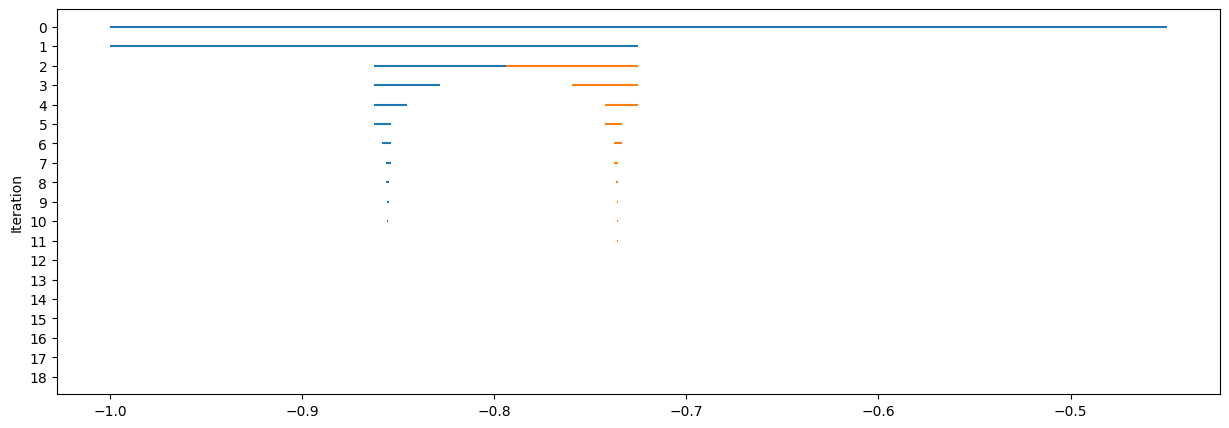

In [14]:
plt.figure(figsize=(15, 5))
for iteration, intervals in enumerate(interval_history):
    for i, interval in enumerate(intervals):
        plt.hlines(iteration, interval[0], interval[1], colors='C'+str(i))
plt.gca().invert_yaxis()
plt.gca().set_yticks(range(len(interval_history)))
plt.ylabel('Iteration')
plt.show()

Видно, как каждый интервал в отдельности сходится к границе погрешности корня, полученной ранее.